In [18]:
print(real_backend.defaults().instruction_schedule_map.get('x',(0,)))

Schedule((0, Play(Drag(duration=160, amp=(0.11858580819838016+0j), sigma=40, beta=0.5754388359123445, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), name="x")


In [6]:
print(real_backend.defaults())

<PulseDefaults(<InstructionScheduleMap(1Q instructions:
  q0: {'sx', 'measure', 'x', 'id', 'u1', 'u3', 'u2', 'rz'}
  q1: {'sx', 'measure', 'x', 'id', 'u1', 'u3', 'u2', 'rz'}
  q2: {'sx', 'measure', 'x', 'id', 'u1', 'u3', 'u2', 'rz'}
  q3: {'sx', 'measure', 'x', 'id', 'u1', 'u3', 'u2', 'rz'}
  q4: {'sx', 'measure', 'x', 'id', 'u1', 'u3', 'u2', 'rz'}
Multi qubit instructions:
  (0, 1): {'cx'}
  (1, 0): {'cx'}
  (1, 2): {'cx'}
  (1, 3): {'cx'}
  (2, 1): {'cx'}
  (3, 1): {'cx'}
  (3, 4): {'cx'}
  (4, 3): {'cx'}
  (0, 1, 2, 3, 4): {'measure'}
)>Qubit Frequencies [GHz]
[5.029751527829769, 5.1277429485605195, 5.24735324351585, 5.302637199942976, 5.092039891820696]
Measurement Frequencies [GHz]
[7.425143125, 7.22164672, 7.471842939, 7.365317232, 7.419067567] )>


# Waveform

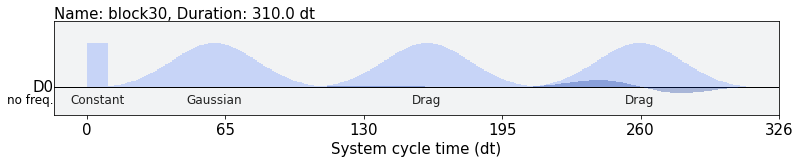

In [33]:
from qiskit import  pulse

d0 = pulse.DriveChannel(0)

with pulse.build() as pulse_prog:
    pulse.play(pulse.Constant(10, 1.0), d0)
    pulse.play(pulse.Gaussian(100, 1.0, 20 ), d0)
    pulse.play(pulse.Drag(100, 1.0, 20, 0.5),d0)
    pulse.play(pulse.Drag(100, 1.0, 20, 5),d0)

pulse_prog.draw()

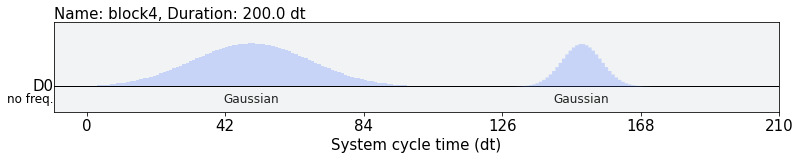

In [6]:
from qiskit import  pulse

d0 = pulse.DriveChannel(0)

with pulse.build() as pulse_prog:
    pulse.play(pulse.Gaussian(100, 0.5,18), d0)
    pulse.play(pulse.Gaussian(100, 0.5, 6 ), d0)
   
pulse_prog.draw()

# Calibrations

In [1]:
import pandas as pd
import numpy as np

import qiskit.pulse as pulse
from qiskit.circuit import Parameter

from qiskit_experiments.calibration_management.calibrations import Calibrations

from qiskit import IBMQ, schedule


In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
real_backend = provider.get_backend('ibmq_lima')

In [3]:
qubit=0

In [8]:
def setup_cals(backend) -> Calibrations:
    """A function to instantiate calibrations and add a couple of template schedules."""
    cals = Calibrations.from_backend(backend)

    dur = Parameter("dur")
    amp = Parameter("amp")
    sigma = Parameter("σ")
    beta = Parameter("β")
    drive = pulse.DriveChannel(Parameter("ch0"))

    # Define and add template schedules.
    with pulse.build(name="xp") as xp:
        pulse.play(pulse.Drag(dur, amp, sigma, beta), drive)

    with pulse.build(name="xm") as xm:
        pulse.play(pulse.Drag(dur, -amp, sigma, beta), drive)

    with pulse.build(name="x90p") as x90p:
        pulse.play(pulse.Drag(dur, Parameter("amp"), sigma, Parameter("β")), drive)

    cals.add_schedule(xp, num_qubits=1)
    cals.add_schedule(xm, num_qubits=1)
    cals.add_schedule(x90p, num_qubits=1)

    return cals

def add_parameter_guesses(cals: Calibrations):
    """Add guesses for the parameter values to the calibrations."""
    for sched in ["xp", "x90p"]:
        cals.add_parameter_value(80, "σ", schedule=sched)
        cals.add_parameter_value(0.5, "β", schedule=sched)
        cals.add_parameter_value(320, "dur", schedule=sched)
        cals.add_parameter_value(0.5, "amp", schedule=sched)

In [9]:
cals = setup_cals(backend)
add_parameter_guesses(cals)

In [10]:
cals.get_schedule('xp',(0,))

ScheduleBlock(Play(Drag(duration=320, amp=(0.5+0j), sigma=80, beta=0.5), DriveChannel(0)), name="xp", transform=AlignLeft())

In [153]:
print(cals.default_inst_map)

<InstructionScheduleMap(1Q instructions:
  q0: {'x90p', 'xm', 'xp'}
  q1: {'x90p', 'xm', 'xp'}
  q2: {'x90p', 'xm', 'xp'}
  q3: {'x90p', 'xm', 'xp'}
  q4: {'x90p', 'xm', 'xp'}
Multi qubit instructions:
)>


In [61]:
print(cals.get_inst_map())

<InstructionScheduleMap(1Q instructions:
  q0: {'x90p', 'xm', 'xp'}
  q1: {'x90p', 'xm', 'xp'}
  q2: {'x90p', 'xm', 'xp'}
  q3: {'x90p', 'xm', 'xp'}
  q4: {'x90p', 'xm', 'xp'}
Multi qubit instructions:
)>


In [1]:
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon

In [6]:
library = FixedFrequencyTransmon(default_values={"duration": 320})
cals = Calibrations.from_backend(backend, libraries=[library])

In [7]:
print(cals.default_inst_map)

<InstructionScheduleMap(1Q instructions:
  q0: {'sx', 'sy', 'y', 'x'}
  q1: {'sx', 'sy', 'y', 'x'}
  q2: {'sx', 'sy', 'y', 'x'}
  q3: {'sx', 'sy', 'y', 'x'}
  q4: {'sx', 'sy', 'y', 'x'}
Multi qubit instructions:
)>


In [8]:
print(cals.get_inst_map())

<InstructionScheduleMap(1Q instructions:
  q0: {'sx', 'sy', 'y', 'x'}
  q1: {'sx', 'sy', 'y', 'x'}
  q2: {'sx', 'sy', 'y', 'x'}
  q3: {'sx', 'sy', 'y', 'x'}
  q4: {'sx', 'sy', 'y', 'x'}
Multi qubit instructions:
)>


In [11]:
cals.get_schedule('x',(0,))
cals.get_schedule('y',(0,))

ScheduleBlock(Play(Drag(duration=320, amp=0.5j, sigma=80, beta=0), DriveChannel(0)), name="y", transform=AlignLeft())

#  Finding qubits with spectroscopy

In [13]:
from qiskit_experiments.library.calibration.rough_frequency import RoughFrequencyCal

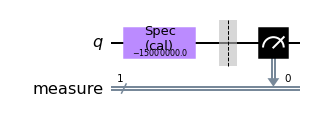

In [14]:
freq01_estimate = backend.defaults().qubit_freq_est[qubit]
frequencies = np.linspace(freq01_estimate -15e6, freq01_estimate + 15e6, 51)
spec = RoughFrequencyCal(qubit, cals, frequencies, backend=backend)
#spec.set_experiment_options(amp=0.005)
circuit = spec.circuits()[0]
circuit.draw(output="mpl")


Schedule((0, ShiftFrequency(-15000000, DriveChannel(0))), (0, Play(GaussianSquare(duration=1072, amp=(0.1+0j), sigma=256.0, width=0.0), DriveChannel(0))), (1072, ShiftFrequency(15000000, DriveChannel(0))), (1072, Acquire(22400, AcquireChannel(0), MemorySlot(0))), (1072, Play(GaussianSquare(duration=22400, amp=(0.008884250867537706-0.023368142556109493j), sigma=64, width=22144, name='M_m0'), MeasureChannel(0), name='M_m0')), (23472, Delay(1680, MeasureChannel(0))), name="circuit-122")


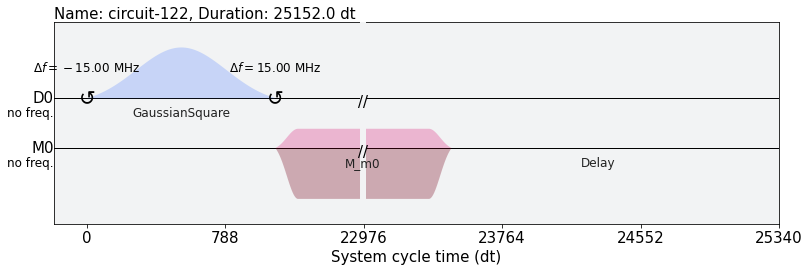

In [16]:
print(schedule(circuit,backend))
schedule(circuit, backend).draw()

In [30]:
spec_data = spec.run().block_for_results()

In [ ]:
spec_data.figure(0)

In [ ]:
print(spec_data.analysis_results("f01"))

# Rabi
### make own calibration -> extract the cal reflected schedule

In [17]:
def setup_cals(backend) -> Calibrations:
    """A function to instantiate calibrations and add a couple of template schedules."""
    cals = Calibrations.from_backend(backend)

    dur = Parameter("dur")
    amp = Parameter("amp")
    sigma = Parameter("σ")
    beta = Parameter("β")
    
    drive = pulse.DriveChannel(Parameter("ch0"))

    # Define and add template schedules.
    with pulse.build(name="x") as x:
        pulse.play(pulse.Drag(dur, amp, sigma, beta), drive)

    with pulse.build(name="sx") as sx:
        pulse.play(pulse.Drag(dur, -amp, sigma, beta), drive)

    with pulse.build(name="x90p") as x90p:
        pulse.play(pulse.Drag(dur, Parameter("amp"), sigma, Parameter("β")), drive)

    cals.add_schedule(x, num_qubits=1)
    cals.add_schedule(sx, num_qubits=1)
    # cals.add_schedule(x90p, num_qubits=1)

    return cals

def add_parameter_guesses(cals: Calibrations):
    """Add guesses for the parameter values to the calibrations."""
    for sched in ["x", "sx"]:
        cals.add_parameter_value(80, "σ", schedule=sched)
        cals.add_parameter_value(0.5, "β", schedule=sched)
        cals.add_parameter_value(320, "dur", schedule=sched)
        cals.add_parameter_value(0.5, "amp", schedule=sched)

cals_rabi = setup_cals(backend)
add_parameter_guesses(cals_rabi)

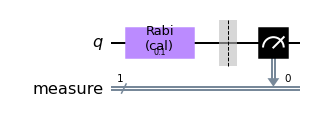

In [21]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal
rabi = RoughXSXAmplitudeCal(qubit, cals_rabi, backend=backend, amplitudes=np.linspace(-0.1, 0.1, 51))
rabi.circuits()[50].draw("mpl")

Schedule((0, Play(Drag(duration=320, amp=(-0.08+0j), sigma=80, beta=0.5), DriveChannel(0))), (320, Acquire(22400, AcquireChannel(0), MemorySlot(0))), (320, Play(GaussianSquare(duration=22400, amp=(0.008884250867537706-0.023368142556109493j), sigma=64, width=22144, name='M_m0'), MeasureChannel(0), name='M_m0')), (22720, Delay(1680, MeasureChannel(0))), name="circuit-231")


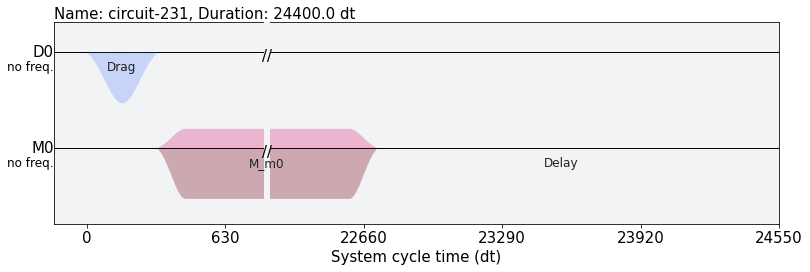

In [22]:
circuit=rabi.circuits()[5]
rabi_sched=schedule(circuit,backend)
print(rabi_sched)
schedule(circuit, backend).draw()

In [54]:
rabi.circuits()[0].calibrations.items()

dict_items([('Rabi', {((0,), (-0.1,)): ScheduleBlock(Play(Drag(duration=320, amp=(-0.1+0j), sigma=80, beta=0.5), DriveChannel(0)), name="x", transform=AlignLeft())})])

### solve the rabi schedule / rabi signal

In [42]:
import numpy as np
from qiskit.quantum_info import Operator
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver
# dt=0.222
# r = 0.1
# w = 5.03
# drift = 2 * np.pi * w * Z/2
# operators = [2 * np.pi * r * X/2]
# # construct the solver
# solver = Solver(
#     static_hamiltonian=drift,
#     hamiltonian_operators=operators,
#     rotating_frame=drift,
#     rwa_cutoff_freq=2 * 5.0,
#     hamiltonian_channels=['d0'],
#     channel_carrier_freqs={'d0': w},
#     dt=dt
# )
#############################################
# nu_z = 5.03
# nu_x = 1.
# nu_d = 5.029  # Almost on resonance with the Hamiltonian's energy levels difference, nu_z

# X = Operator.from_label('X')
# Y = Operator.from_label('Y')
# Z = Operator.from_label('Z')

# solver = Solver(
#     static_hamiltonian=.5 * 2 * np.pi * nu_z * Z,
#     hamiltonian_operators=[2 * np.pi * nu_x * X],
# )

dt=0.222
r = 0.1
w = 5.03
X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')

drift = 2 * np.pi * w * Z/2
operators = [2 * np.pi * r * X/2]
converter = InstructionToSignals(dt, carriers={"d0": w})
signals = converter.get_signals(rabi_sched)
# construct the solver
solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=operators,
    rotating_frame=drift,
    rwa_cutoff_freq=2 * 5.0,
    hamiltonian_channels=['d0'],
    channel_carrier_freqs={'d0': w},
    dt=dt
)

In [53]:
import numpy as np
from qiskit.quantum_info import Operator
from qiskit.quantum_info.states import Statevector
y0 = Statevector([1., 0.])
t_final = .5 / nu_x
n_steps = int(np.ceil(t_final / tau)) + 1
t_eval = np.linspace(0., t_final, n_steps)
# signals position : either in Signal format or as Qiskit Pulse Schedules
#sol=solver.solve(t_span=[0., 20], y0=y0, signals=[signals[0]], t_eval=t_eval)
sol=solver.solve(t_span=[0., 20], y0=y0, signals=rabi_sched, t_eval=t_eval)

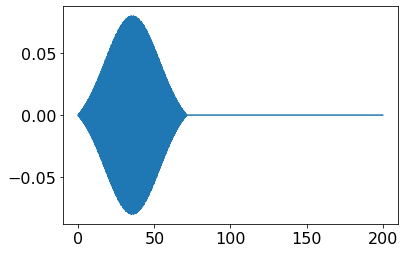

In [45]:
signals[0].draw(0,200, 20000)

In [55]:
for a in signals:
    print(a)

d0
a0
m0


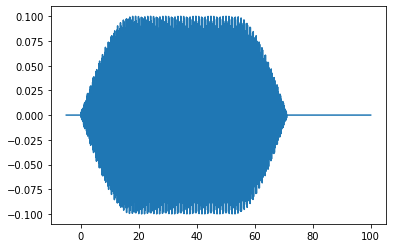

In [114]:
signals[0].draw(-5,100,2000)

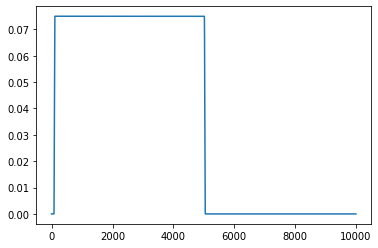

In [70]:
signals[1].draw(-10,10000,20000)

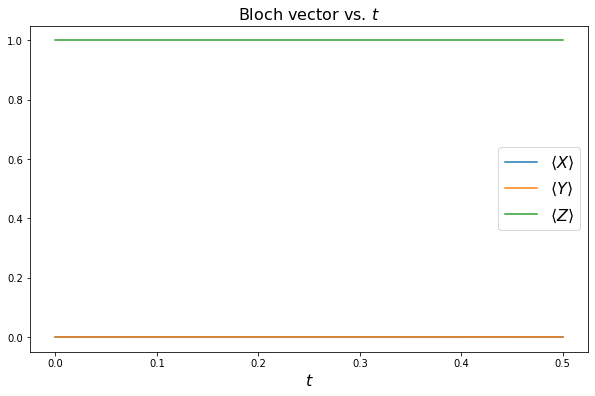

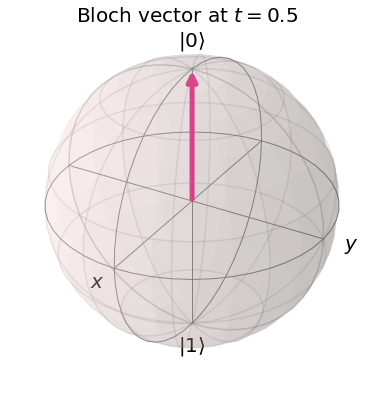

In [46]:
from qiskit.visualization import plot_bloch_vector
import matplotlib.pyplot as plt
%matplotlib inline

fontsize = 16

def plot_qubit_dynamics(sol, t_eval, X, Y, Z):
    n_times = len(sol.y)
    x_data = np.zeros((n_times,))
    y_data = np.zeros((n_times,))
    z_data = np.zeros((n_times,))

    for t_i, sol_t in enumerate(sol.y):
        x_data[t_i] = sol_t.expectation_value(X).real
        y_data[t_i] = sol_t.expectation_value(Y).real
        z_data[t_i] = sol_t.expectation_value(Z).real

    _, ax = plt.subplots(figsize = (10, 6))
    plt.rcParams.update({'font.size': fontsize})
    plt.plot(t_eval, x_data, label = '$\\langle X \\rangle$')
    plt.plot(t_eval, y_data, label = '$\\langle Y \\rangle$')
    plt.plot(t_eval, z_data, label = '$\\langle Z \\rangle$')
    plt.legend(fontsize = fontsize)
    ax.set_xlabel('$t$', fontsize = fontsize)
    ax.set_title('Bloch vector vs. $t$', fontsize = fontsize)
    plt.show()

    display(plot_bloch_vector([x_data[-1], y_data[-1], z_data[-1]],
                              f'Bloch vector at $t = {t_eval[-1]}$'))

plot_qubit_dynamics(sol, t_eval, X, Y, Z)

In [191]:
rabi_data = rabi.run().block_for_results()

c:\Users\kimje\anaconda3\envs\qiskit_JW\lib\site-packages\numpy\lib\function_base.py:2387: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


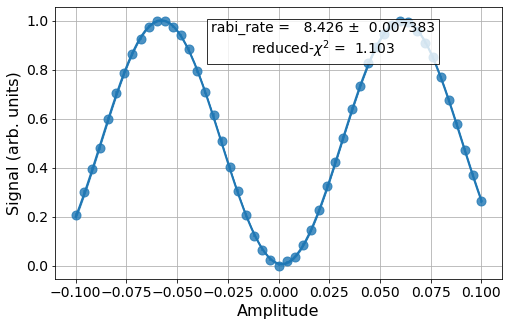

In [192]:
rabi_data.figure(0)

In [193]:
print(rabi_data.analysis_results("rabi_rate"))

AnalysisResult
- name: rabi_rate
- value: 8.426+/-0.007
- χ²: 1.1033915520084614
- quality: good
- device_components: ['Q0']
- verified: False


# Test

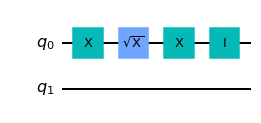

In [7]:
from qiskit import QuantumCircuit


qc=QuantumCircuit(2)
qc.x(0)
qc.sx(0)
qc.x(0)
qc.id(0)
qc.draw(output='mpl')

In [8]:
schedule(qc, backend)

NameError: name 'backend' is not defined

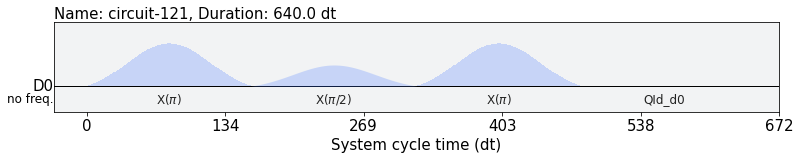

In [8]:
schedule(qc, backend).draw()

In [9]:
qc.calibrations

{}

In [20]:
dur = Parameter("dur")
amp = Parameter("amp")
sigma = Parameter("σ")
beta = Parameter("β")
    
drive = pulse.DriveChannel(Parameter("ch0"))

# Define and add template schedules.
with pulse.build(name="x") as x:
    pulse.play(pulse.Drag(dur, amp, sigma, beta), drive)
qc2=QuantumCircuit(2)
qc2.x(0)
qc2.sx(0)
qc2.add_calibration('x',[0],x)
qc2.calibrations.items()


dict_items([('x', {((0,), ()): ScheduleBlock(Play(Drag(duration=dur, amp=amp, sigma=σ, beta=β), DriveChannel(ch0)), name="x", transform=AlignLeft())})])

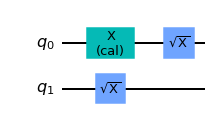

In [1]:
from qiskit import pulse
from qiskit.pulse.library import Gaussian, Drag
from qiskit.providers.fake_provider import FakeValencia
from qiskit import QuantumCircuit
from qiskit_experiments.calibration_management.calibrations import Calibrations

from qiskit import IBMQ, schedule

backend = FakeValencia()

with pulse.build(backend, name='xp') as xp:
    pulse.play(Gaussian(duration=128, amp=0.1, sigma=16), pulse.drive_channel(0))
with pulse.build(backend, name='xhp') as xhp:
    pulse.play(Drag(duration=128, amp=0.1, sigma=16, beta=1), pulse.drive_channel(0))

qc1=QuantumCircuit(2)
qc1.x(0)
qc1.sx(0)
qc1.sx(1)
qc1.add_calibration('x',[0],xp)
qc1.draw(output='mpl')

In [17]:
print(backend.defaults())

<PulseDefaults(<InstructionScheduleMap(1Q instructions:
  q0: {'sx', 'measure', 'x', 'id', 'u1', 'u3', 'u2', 'rz'}
  q1: {'sx', 'measure', 'x', 'id', 'u1', 'u3', 'u2', 'rz'}
  q2: {'sx', 'measure', 'x', 'id', 'u1', 'u3', 'u2', 'rz'}
  q3: {'sx', 'measure', 'x', 'id', 'u1', 'u3', 'u2', 'rz'}
  q4: {'sx', 'measure', 'x', 'id', 'u1', 'u3', 'u2', 'rz'}
Multi qubit instructions:
  (0, 1): {'cx'}
  (1, 0): {'cx'}
  (1, 2): {'cx'}
  (1, 3): {'cx'}
  (2, 1): {'cx'}
  (3, 1): {'cx'}
  (3, 4): {'cx'}
  (4, 3): {'cx'}
  (0, 1, 2, 3, 4): {'measure'}
)>Qubit Frequencies [GHz]
[4.743892440131272, 4.660914072609433, 4.792493277895261, 4.834410370035304, 4.959527978256725]
Measurement Frequencies [GHz]
[7.291423281, 7.064734703, 7.209148181000001, 7.137515922, 6.984029338] )>


In [10]:
schedule(qc1,backend)

Schedule((0, Play(Gaussian(duration=128, amp=(0.1+0j), sigma=16), DriveChannel(0))), (128, Play(Drag(duration=160, amp=(0.09618851775276127+0.0008448724348311288j), sigma=40, beta=-0.35835396095069005, name='drag_f8d4'), DriveChannel(0), name='drag_f8d4')), (128, Play(Drag(duration=160, amp=(0.07463911808570808+0.0005895511142621901j), sigma=40, beta=-0.5196057292826135, name='drag_f352'), DriveChannel(1), name='drag_f352')), name="circuit-124")

In [2]:
qc1.calibrations.items()

dict_items([('x', {((0,), ()): ScheduleBlock(Play(Gaussian(duration=128, amp=(0.1+0j), sigma=16), DriveChannel(0)), name="xp", transform=AlignLeft())})])

In [14]:
import copy
import datetime
from functools import lru_cache
from typing import Dict, List, Optional, Tuple, Union

import numpy as np

from qiskit import QuantumCircuit
from qiskit.circuit import CircuitInstruction
from qiskit.circuit.measure import Measure
from qiskit.providers import BackendV2, QubitProperties
from qiskit.providers.models import PulseDefaults
from qiskit.providers.options import Options
from qiskit.pulse import ScheduleBlock
from qiskit.pulse.transforms import block_to_schedule
from qiskit.qobj.utils import MeasLevel, MeasReturnType
from qiskit.quantum_info.states import Statevector
from qiskit.result import Result
from qiskit.transpiler import InstructionProperties, Target

from qiskit_dynamics import Solver
from qiskit_dynamics.pulse import InstructionToSignals

from qiskit_experiments.exceptions import QiskitError
from qiskit_experiments.test.utils import FakeJob


class IQPulseBackend(BackendV2):
    """Pulse Simulator abstract class"""

    def __init__(
        self,
        static_hamiltonian: np.ndarray,
        hamiltonian_operators: np.ndarray,
        dt: Optional[float] = 0.1 * 1e-9,
        **kwargs,
    ):
        """Hamiltonian and operators is the Qiskit Dynamics object"""
        super().__init__(
            None,
            name="PulseBackendV2",
            description="A PulseBackend simulator",
            online_date=datetime.datetime.utcnow(),
            backend_version="0.0.1",
        )
        self._defaults = PulseDefaults.from_dict(
            {
                "qubit_freq_est": [0],
                "meas_freq_est": [0],
                "buffer": 0,
                "pulse_library": [],
                "cmd_def": [],
            }
        )
        self.converter = None

        self.static_hamiltonian = static_hamiltonian
        self.hamiltonian_operators = hamiltonian_operators
        self.solver = Solver(self.static_hamiltonian, self.hamiltonian_operators, **kwargs)
        self._target = Target(dt=dt, granularity=16)
        self.gound_state = np.zeros(self.solver.model.dim)
        self.gound_state[0] = 1
        self.y_0 = np.eye(self.solver.model.dim)

   # why PulseDefault needed?
   # just define the initial default pulse is fine I tink!
    @property
    def default_pulse_unitaries(self) -> Dict[Tuple, np.array]:
        """Return the default unitary matrices of the backend."""
        return self._simulated_pulse_unitaries

    @default_pulse_unitaries.setter
    def default_pulse_unitaries(self, unitaries: Dict[Tuple, np.array]):
        """Set the default unitary pulses this allows the tests to simulate the pulses only once."""
        self._simulated_pulse_unitaries = unitaries

    @property
    def target(self):
        return self._target

    @property
    def max_circuits(self):
        return None

    def defaults(self): 
        """return backend defaults"""
        return self._defaults

    @classmethod
    def _default_options(cls):
        return Options(shots=1024)

    @staticmethod
    def _get_info(instruction: CircuitInstruction) -> Tuple[Tuple[int], Tuple[float], str]:
        p_dict = instruction.operation
        qubit = tuple(int(str(val)[-2]) for val in instruction.qubits)
        params = tuple(float(val) for val in p_dict.params)
        return qubit, params, p_dict.name

    @staticmethod
    def _state_vector_to_unitary ( 
        state: Union[Statevector, np.ndarray],
        shots: Optional[int] = 1024,
        meas_return: Optional[MeasReturnType] = 0,
        meas_level: Optional[MeasLevel] = 0,
    ) -> Union[Dict[str, int], complex]:
        """Convert the state vector to IQ data or counts."""

        if meas_level == MeasLevel.CLASSIFIED:
            measurement = Statevector(state).sample_counts(shots)
        elif meas_level == MeasLevel.KERNELED:
            raise QiskitError("TODO: generate IQ data")
            # measurement = iq_data = ... #create IQ data.
            # Q5
        if meas_return == "avg":
            return np.average(list(measurement.keys()), weights=list(measurement.values()))
        else:
            return measurement

    @lru_cache
    def solve(self, schedule_blocks: ScheduleBlock, qubits: Tuple[int]) -> np.ndarray:
        """Solves a single schdule block and returns the unitary"""
        if len(qubits) > 1:
            QiskitError("TODO multi qubit gates")
        
        signal = self.converter.get_signals(schedule_blocks)
        #schedule = block_to_schedule(schedule_blocks)
        #signal = self.converter.get_signals(schedule)
        time_f = schedule_blocks.duration * self.dt
        unitary   = self.solver.solve(
            t_span=[0.0, time_f],
            y0=self.y_0,
            t_eval=[time_f],
            signals=signal,
            method="RK23", #?
        ).y[0] 

        return unitary 
 
    def run(self, run_input: Union[QuantumCircuit, List[QuantumCircuit]], **options) -> FakeJob:
        """run method takes circuits as input and returns FakeJob object with unitary s """

        self.options.update_options(**options)
        shots = self.options.get("shots")
        meas_level = self.options.get("meas_level")

        unitary   = {
            "backend_name": f"{self.__class__.__name__}",
            "backend_version": self.backend_version,
            "qobj_id": 0,
            "job_id": 0,
            "success": True,
            "unitary s ": [],
        }

        if isinstance(run_input, QuantumCircuit):
            run_input = [run_input]

        experiment_unitaries = copy.deepcopy(self.default_pulse_unitaries)

        for circuit in run_input:
            for name, schedule in circuit.calibrations.items():
                for (qubits, params), schedule_block in schedule.items():
                    if (name, qubits, params) not in experiment_unitaries:
                        experiment_unitaries[(name, qubits, params)] = self.solve(
                            schedule_block, qubits
                        )#schedule_block -> schedule

            psi = self.gound_state.copy()
            for instruction in circuit.data:
                qubits, params, inst_name = self._get_info(instruction)
                if inst_name in ["barrier", "measure"]:
                    continue
                unitary = experiment_unitaries[(inst_name, qubits, params)]
                psi = unitary @ psi

            counts = self._state_vector_to_unitary ( psi / np.linalg.norm(psi), **options)
            # counts = dict(zip(*np.unique(memory, return_counts=True)))
            run_unitary   = {
                "shots": shots,
                "success": True,
                "header": {"metadata": circuit.metadata},
                "meas_level": meas_level,
                "data": {
                    "counts": counts,
                    # "memory": memory,
                },
            }

            unitary [ "unitary s "].append(run_unitary ) 
        return FakeJob(self, unitary . from_dict(unitary ) )


class SingleTransmonTestBackend(IQPulseBackend):
    """Three level anharmonic transmon qubit"""

    def __init__(self, omega_01: float, delta: float, lambda_0: float, lambda_1: float):

        omega_02 = 2 * omega_01 + delta
        ket0 = np.array([[1, 0, 0]]).T
        ket1 = np.array([[0, 1, 0]]).T
        ket2 = np.array([[0, 0, 1]]).T

        sigma_m1 = ket0 @ ket1.T.conj()
        sigma_m2 = ket1 @ ket2.T.conj()

        sigma_p1 = sigma_m1.T.conj()
        sigma_p2 = sigma_m2.T.conj()

        p1 = ket1 @ ket1.T.conj()
        p2 = ket2 @ ket2.T.conj()

        drift = 2 * np.pi * (omega_01 * p1 + omega_02 * p2)
        control = [
            2 * np.pi * (lambda_0 * (sigma_p1 + sigma_m1) + lambda_1 * (sigma_p2 + sigma_m2))
        ]
        r_frame = 2 * np.pi * (omega_01 * p1 + 2 * omega_01 * p2)

        super().__init__(
            static_hamiltonian=drift,
            hamiltonian_operators=control,
            rotating_frame=r_frame,
            rwa_cutoff_freq=1.9 * omega_01,
            rwa_carrier_freqs=[omega_01],
        )

        self._defaults = PulseDefaults.from_dict(
            {
                "qubit_freq_est": [omega_01 / 1e9],
                "meas_freq_est": [0],
                "buffer": 0,
                "pulse_library": [],
                "cmd_def": [],
            }
        )
        self._target = Target(
            qubit_properties=[QubitProperties(frequency=omega_01)], dt=self.dt, granularity=16
        )
        measure_props = {
            (0,): InstructionProperties(duration=0, error=0),
        }
        self._target.add_instruction(Measure(), measure_props)
        self.converter = InstructionToSignals(self.dt, carriers={"d0": omega_01})

    def default_pulse_unitaries(self)  -> Dict[Tuple, np.array]:
        """Return the default unitary matrices of the backend."""
        default_schedule=[]
        d0 = pulse.DriveChannel(0)
        with pulse.build() as x:
            pulse.play(Drag(duration=160, amp=0.1, sigma=16, beta=5), d0)
            default_schedule.append(x)
        with pulse.build() as sx:
            pulse.play(Drag(duration=160, amp=0.1*0.5, sigma=16, beta=5), d0)
            default_schedule.append(sx)
        default_unitaries=[]
        #defualt_unitaries.append(RZ)
        for schedule in default_schedule:
            signal=self.converter.get_signals(schedule)
            T=schedule.duration*self.dt
            unitary = self.solver.solve(t_span=[0.0,T], y0=self.y_0,
                                    t_eval=[T], signals=signal,
                                    method='RK23').y[0]
            default_unitaries.append(unitary) 
        
        return default_unitaries

In [15]:
pulse_backend = SingleTransmonTestBackend(5.0e9,-.25e9, 1e9, 0.8e9)

In [18]:
import numpy as np
from qiskit_dynamics import Solver
from qiskit.quantum_info.states import Statevector
Omega_01 = 5.0  # Ghz
Delta = -0.25
Omega_02 = 2 * Omega_01 + Delta
Lambda = 0.8

ket0 = np.array([[1, 0, 0]]).T
ket1 = np.array([[0, 1, 0]]).T
ket2 = np.array([[0, 0, 1]]).T

sigma_m1 = ket0 @ ket1.T.conj()
sigma_m2 = ket1 @ ket2.T.conj()

sigma_p1 = sigma_m1.T.conj()
sigma_p2 = sigma_m2.T.conj()

P0, P1, P2 = ket0 @ ket0.T.conj(), ket1 @ ket1.T.conj(), ket2 @ ket2.T.conj()
# drift, control, R_frame
drift = 2 * np.pi * (Omega_01 * P1 + Omega_02 * P2)
control = [2 * np.pi * (sigma_p1 + sigma_m1 + Lambda * (sigma_p2 + sigma_m2))]
R_frame = 2 * np.pi * (Omega_01 * P1 + 2 * Omega_01 * P2)
y0 = Statevector([1.0, 0.0, 0.0])
y_0 = np.eye(3)
dt = 0.1
area = 0.4
sigma = 5  # ns
# amp = area / sigma
sigma = sigma / dt  # ns

duration = np.math.ceil(sigma * 5)
T = duration * dt  # ns
# construct the solver
hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=control,
    rotating_frame=R_frame,
    rwa_cutoff_freq=1.5 * Omega_01,
    rwa_carrier_freqs=[Omega_01],
)
d0 = pulse.DriveChannel(0)
with pulse.build() as x:
    pulse.play(Drag(duration=160, amp=0.1, sigma=16, beta=5), d0)
solutions = hamiltonian_solver.solve(
                            t_span=[0.0, T],
                            y0=y_0,
                            t_eval=[T],
                            signals=pulse_backend.converter.get_signals(x) )


In [36]:
experiment_unitaries={}
for name, schedule in qc1.calibrations.items():
    print(name)
    print(schedule)
    for (qubits, params), schedule_block in schedule.items():
        print(qubits)
        print(params)
        print(schedule_block)
        if (name, qubits, params) not in experiment_unitaries:
            print('a')
            print(name,qubits,params)
        

x
{((0,), ()): ScheduleBlock(Play(Gaussian(duration=128, amp=(0.1+0j), sigma=16), DriveChannel(0)), name="xp", transform=AlignLeft())}
(0,)
()
ScheduleBlock(Play(Gaussian(duration=128, amp=(0.1+0j), sigma=16), DriveChannel(0)), name="xp", transform=AlignLeft())
a
x (0,) ()


In [27]:
experiment_unitaries[(name,qubits,params)]=solutions

In [35]:
if ('x', (0,), ()) in experiment_unitaries:
            print('a')
else :
    print('b')

a


In [29]:
experiment_unitaries

{('x',
  (0,),
  ()):   message: 'The solver successfully reached the end of the integration interval.'
      nfev: 209
      njev: 0
       nlu: 0
       sol: None
    status: 0
   success: True
         t: array([25.])
  t_events: None
         y: Array([[[ 1.00000000e+00+0.00000000e+00j,
           1.05124478e-08-6.77028087e-09j,
           0.00000000e+00+0.00000000e+00j],
         [-1.05124478e-08-6.77028087e-09j,
           1.00000000e+00+0.00000000e+00j,
           8.40995827e-09-5.41622469e-09j],
         [ 0.00000000e+00+0.00000000e+00j,
           5.36889267e-09-8.43186981e-09j,
           2.89515413e-03+9.94746843e-01j]]])
  y_events: None}

In [13]:
qc1.data

[CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 1),), clbits=())]

In [14]:
from qiskit.circuit import CircuitInstruction
def _get_info(instruction: CircuitInstruction):
        p_dict = instruction.operation
        qubit = tuple(int(str(val)[-2]) for val in instruction.qubits)
        params = tuple(float(val) for val in p_dict.params)
        return qubit, params, p_dict.name

In [15]:
for instruction in qc1.data:
    a=_get_info(instruction)
    print(a)

((0,), (), 'x')
((0,), (), 'sx')
((1,), (), 'sx')


In [130]:
cal_operator=[]
for index,(key,elem) in enumerate(qc1.calibrations.items()):
    print(key)
    cal_operator.append(key)
print(cal_operator)


x
['x']


In [37]:
backend.configuration().hamiltonian['qub']

{'0': 3, '1': 3, '2': 3, '3': 3, '4': 3}

In [8]:
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel
from qiskit.compiler import assemble

p_sim=PulseSimulator()
p_mod=PulseSystemModel().from_backend(backend)

circuit_unitaries = {}

for inst_name, instructions in qc1.calibrations.items():
    circuit_unitaries[inst_name] = instructions
    for qubit_params, schedule in instructions.items():
        qobj=assemble(schedule, p_sim)
        unitary = p_sim.run(qobj, system_model=p_mod)
        circuit_unitaries[inst_name][qubit_params] = unitary # schedule대신에unitary(Aerjob?)
        